**File name**: main_keras_realization.ipynb<br>
**Authors**: Anton Lukashchuk &lt;[academik116@gmail.com](mailto:academik116@gmail.com)&gt;, Anton Karazeev &lt;[anton.karazeev@gmail.com](mailto:anton.karazeev@gmail.com)&gt;, Maxim Karpov &lt;[maxim.karpov@epfl.ch](mailto:maxim.karpov@epfl.ch)&gt; <br>
This file is part of REDE project (https://github.com/akarazeev/REDE)

In [8]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

# Silence warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import os
import tqdm
import pickle
import scipy.io as spio

from IPython.display import Image

np.random.seed(123)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

In [5]:
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import Input, Dense
from keras.layers import Activation, Flatten
from keras.layers import MaxPool2D, Dropout, BatchNormalization
from keras.utils import plot_model
from keras import utils


In [63]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [718]:
with open('data/rede/raw/5070-62-111-images.pkl', 'rb') as f:
    a = pickle.load(f)

In [719]:
a.shape

(5070, 62, 111)

In [599]:
import pickle


with open('data/rede/raw/5070-62-111-images.pkl', 'rb') as f:
    img = pickle.load(f)
    
with open('data/rede/raw/5070-frequencies_modes.pkl', 'rb') as f:
    Disp = pickle.load(f)    
    
with open('data/rede/raw/5070-5-parameters.pkl', 'rb') as f:
    parameters_list = pickle.load(f)

In [600]:
img.shape

(5070, 62, 111)

In [601]:
parameters_list[3010]

array([3.50e-07, 1.55e-06, 8.00e-07, 2.00e-05, 8.80e-07])

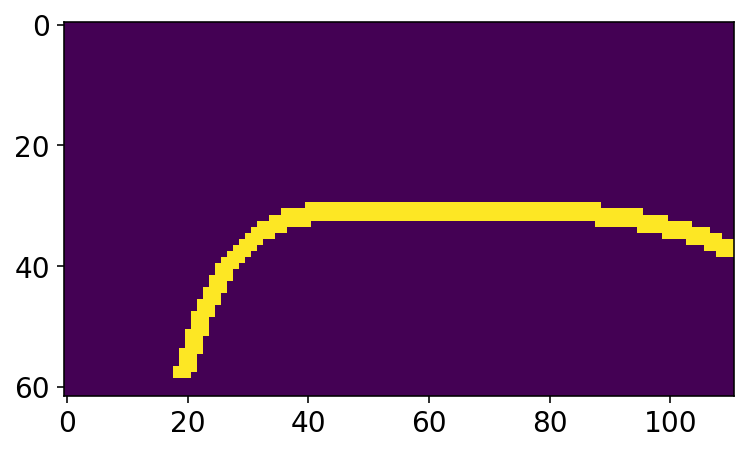

In [603]:
# import matplotlib.cm as cm
# import matplotlib.pyplot as plt


plt.imshow(img[5000])#, cmap=cm.Greys_r)
plt.show()

In [604]:
Disp.shape

(5070, 2, 50)

In [605]:
freq_grid = Disp[0,0,:]
freq_grid

array([1.50e+14, 1.55e+14, 1.60e+14, 1.65e+14, 1.70e+14, 1.75e+14,
       1.80e+14, 1.85e+14, 1.90e+14, 1.95e+14, 2.00e+14, 2.05e+14,
       2.10e+14, 2.15e+14, 2.20e+14, 2.25e+14, 2.30e+14, 2.35e+14,
       2.40e+14, 2.45e+14, 2.50e+14, 2.55e+14, 2.60e+14, 2.65e+14,
       2.70e+14, 2.75e+14, 2.80e+14, 2.85e+14, 2.90e+14, 2.95e+14,
       3.00e+14, 3.05e+14, 3.10e+14, 3.15e+14, 3.20e+14, 3.25e+14,
       3.30e+14, 3.35e+14, 3.40e+14, 3.45e+14, 3.50e+14, 3.55e+14,
       3.60e+14, 3.65e+14, 3.70e+14, 3.75e+14, 3.80e+14, 3.85e+14,
       3.90e+14, 3.95e+14])

In [606]:
Dint = Disp[:,1,:]
Dint.shape

(5070, 50)

In [607]:
X_train, X_test, y_train, y_test = train_test_split(np.array(Dint), np.array(parameters_list)*10**7*[1,1,1,1e-2,1],
                                                  test_size=0.2,
                                                  random_state=42)

In [608]:
X_train.shape

(4056, 50)

In [609]:
sc = StandardScaler()
sc.fit_transform(X_train,y_train)
sc.transform(X_test, y_test)

C:\Users\lukashch\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:675: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)


array([[-0.90867512, -0.86860248, -0.82651408, ...,  0.46336936,
         0.48335698,  0.5020384 ],
       [ 0.55700102,  0.61819261,  0.67060301, ...,  1.28108283,
         1.21810288,  1.16333774],
       [ 0.40467559,  0.44131716,  0.47404122, ...,  0.89987021,
         0.88401011,  0.86797456],
       ...,
       [-0.17308039, -0.19390666, -0.21365399, ..., -0.70282562,
        -0.68739114, -0.6719052 ],
       [ 1.44915211,  1.39588821,  1.34358009, ..., -0.26849714,
        -0.30052332, -0.33099853],
       [-0.39775457, -0.43636651, -0.47323738, ...,  0.30557833,
         0.34187546,  0.37661035]])

In [612]:
inputs = Input(shape=(50,))
x = BatchNormalization()(inputs)
x = Dense(1000,activation='relu')(x)
# x = Dense(50,activation='relu')(x)
# x = Dropout(0.05, noise_shape=None, seed=None)(x)
# x = Dense(22,activation='relu')(inputs)

x = BatchNormalization()(x)
x = Dense(20,activation='relu')(x)
# x = Dropout(0.05, noise_shape=None, seed=None)(x)

x = BatchNormalization()(x)
out = Dense(5,activation='linear')(x)

model = Model(inputs=inputs, outputs=out)

In [613]:
model.compile(optimizer='Nadam',
                loss='mean_squared_error')

In [614]:
history = model.fit(X_train, y_train,
                               batch_size=32,
                               epochs=80, verbose=2,
                               validation_split=.20,
                            )#validation_data=(X_test,y_test))

Train on 3244 samples, validate on 812 samples
Epoch 1/80
 - 8s - loss: 66.9275 - val_loss: 50.2269
Epoch 2/80
 - 4s - loss: 29.3780 - val_loss: 13.6793
Epoch 3/80
 - 2s - loss: 5.8865 - val_loss: 2.2129
Epoch 4/80
 - 2s - loss: 1.0133 - val_loss: 0.5081
Epoch 5/80
 - 2s - loss: 0.3464 - val_loss: 0.3396
Epoch 6/80
 - 2s - loss: 0.2843 - val_loss: 0.2748
Epoch 7/80
 - 2s - loss: 0.2723 - val_loss: 0.2665
Epoch 8/80
 - 2s - loss: 0.2728 - val_loss: 0.2845
Epoch 9/80
 - 3s - loss: 0.2737 - val_loss: 0.2789
Epoch 10/80
 - 2s - loss: 0.2688 - val_loss: 0.2694
Epoch 11/80
 - 2s - loss: 0.2668 - val_loss: 0.2657
Epoch 12/80
 - 2s - loss: 0.2687 - val_loss: 0.2789
Epoch 13/80
 - 2s - loss: 0.2661 - val_loss: 0.2704
Epoch 14/80
 - 4s - loss: 0.2631 - val_loss: 0.2806
Epoch 15/80
 - 3s - loss: 0.2638 - val_loss: 0.2725
Epoch 16/80
 - 4s - loss: 0.2625 - val_loss: 0.2809
Epoch 17/80
 - 3s - loss: 0.2633 - val_loss: 0.2755
Epoch 18/80
 - 2s - loss: 0.2619 - val_loss: 0.2604
Epoch 19/80
 - 2s - lo

Text(0.5,1,'Adam-opt & MSE')

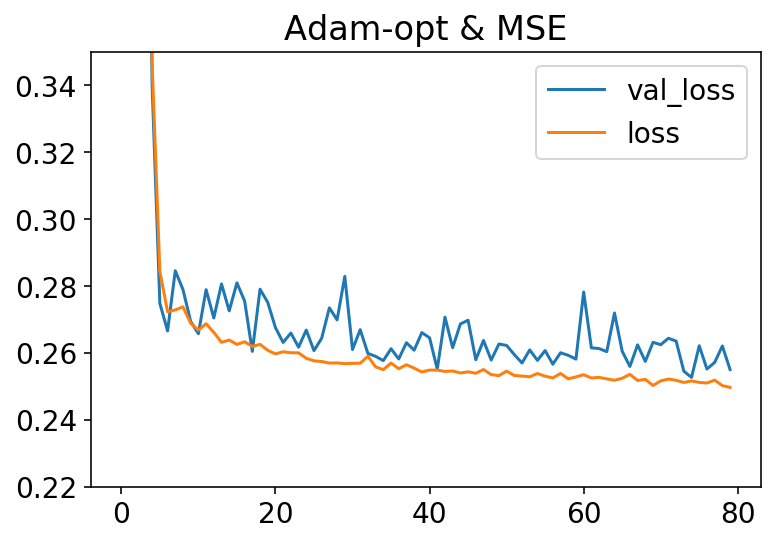

In [621]:
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_acc'], label='val_acc')
# plt.plot(history.history['acc'], label='acc')
plt.ylim([0.22, 0.35])
plt.legend()
plt.title('Adam-opt & MSE')

In [622]:
model.evaluate(X_test,y_test)

1014/1014 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 345us/step


0.25523141443846964

In [623]:
print('mse score  = ', mse(model.predict(X_test),y_test) )

mse score  =  0.25523139403093553


In [466]:
a= np.random.randint(1,len(y_test),10)
a

array([154,  54,  14,  32, 277, 383, 123, 272, 508, 551])

In [468]:
y_test[a]

array([[ 3.5 , 14.5 ,  7.5 ,  2.4 ,  8.  ],
       [ 3.  , 15.5 ,  7.6 ,  1.65,  9.6 ],
       [ 2.5 , 15.5 ,  6.4 ,  1.55,  9.6 ],
       [ 3.5 , 15.5 ,  8.  ,  2.2 ,  8.  ],
       [ 3.  , 15.5 ,  7.2 ,  1.55,  8.4 ],
       [ 3.5 , 15.5 ,  6.8 ,  1.55,  9.6 ],
       [ 3.  , 15.5 ,  8.5 ,  1.8 , 10.  ],
       [ 4.  , 15.  ,  6.  ,  1.75,  7.6 ],
       [ 2.5 , 14.5 ,  7.  ,  2.4 ,  8.4 ],
       [ 4.  , 14.5 ,  8.5 ,  1.9 , 10.  ]])

In [467]:
model.predict(X_test)[a]

array([[ 3.3143342, 14.9358635,  7.576552 ,  1.9447037,  8.548236 ],
       [ 2.9594233, 14.9880295,  7.8288393,  1.9011168,  9.482163 ],
       [ 3.1460183, 15.228081 ,  7.058155 ,  1.9260627,  9.692702 ],
       [ 3.4182646, 15.498358 ,  7.0852118,  1.9343007,  8.853269 ],
       [ 3.3239105, 15.008889 ,  7.32713  ,  1.9090928,  8.689564 ],
       [ 3.0878284, 15.083664 ,  7.5174565,  1.9432529,  9.540515 ],
       [ 3.3618717, 15.127085 ,  8.252455 ,  1.8655368,  9.490334 ],
       [ 3.4425998, 15.472049 ,  7.1377964,  1.9095007,  8.77194  ],
       [ 3.243337 , 15.221086 ,  7.312777 ,  2.0029273,  8.727796 ],
       [ 2.924205 , 14.94679  ,  8.190481 ,  1.8111858,  9.131056 ]],
      dtype=float32)

In [412]:
model.predict(X_test)[0]-y_test[0]

array([-0.22842622, -0.24478626, -0.17896032, -5.30073547, -0.02171631])

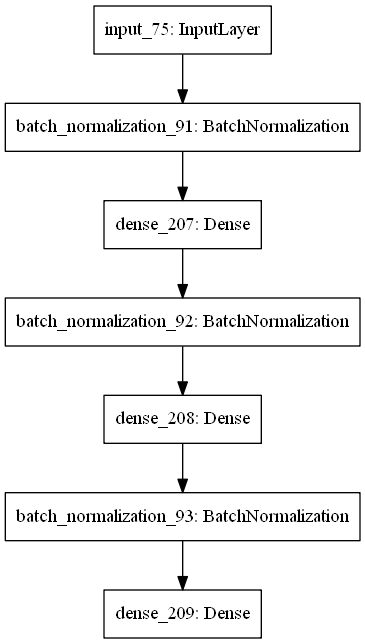

In [728]:
plot_model(model, to_file='img/basic-net.png')

Image(filename="img/basic-net.png")

In [615]:
X_train_im, X_test_im, y_train_im, y_test_im = train_test_split(img, 
                                                np.array(parameters_list)*10**7*[1,1,1,1e-2,1],
                                                test_size=0.2,
                                                random_state=42)

In [616]:
X_train_im = X_train_im.reshape(X_train.shape[0], 62, 111, 1).astype(np.float64)
X_test_im = X_test_im.reshape(X_test.shape[0], 62, 111, 1).astype(np.float64)

In [617]:
X_train_im.shape

(4056, 62, 111, 1)

In [720]:
input_image = Input(shape=(62, 111, 1))
x = Conv2D(16, 5, strides=1, activation='relu')(input_image)
x = MaxPool2D(2, strides=2)(x)
x = Conv2D(32, 4, strides=2, activation='relu')(input_image)
x = MaxPool2D(2, strides=2)(x)
x = Conv2D(64, 3, strides=2, activation='relu')(x)
x = MaxPool2D(2, strides=2)(x)

x = Flatten()(x)

x = Dense(100, activation='relu')(x)
x = Dense(5, activation='linear')(x)
convnet = Model(inputs=input_image, outputs=x)

In [721]:
convnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_90 (InputLayer)        (None, 62, 111, 1)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 30, 54, 32)        544       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 15, 27, 32)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 7, 13, 64)         18496     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 3, 6, 64)          0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 1152)              0         
_________________________________________________________________
dense_243 (Dense)            (None, 100)               115300    
__________

In [693]:
convnet.compile(optimizer='adam',
                loss='mean_squared_error'
                )

In [694]:

history_callback = convnet.fit(X_train_im, y_train_im,
                               batch_size=32,
                               epochs=50, verbose=2,
                               validation_data=(X_test_im, y_test_im))

Train on 3244 samples, validate on 812 samples
Epoch 1/100
 - 12s - loss: 11.3847 - val_loss: 1.2981
Epoch 2/100
 - 8s - loss: 0.9760 - val_loss: 0.8620
Epoch 3/100
 - 8s - loss: 0.6764 - val_loss: 0.6610
Epoch 4/100
 - 8s - loss: 0.5476 - val_loss: 0.5631
Epoch 5/100
 - 8s - loss: 0.4679 - val_loss: 0.5158
Epoch 6/100
 - 8s - loss: 0.4233 - val_loss: 0.4626
Epoch 7/100
 - 8s - loss: 0.3811 - val_loss: 0.4651
Epoch 8/100
 - 8s - loss: 0.3600 - val_loss: 0.4291
Epoch 9/100
 - 8s - loss: 0.3387 - val_loss: 0.4065
Epoch 10/100
 - 8s - loss: 0.3193 - val_loss: 0.4005
Epoch 11/100
 - 8s - loss: 0.3066 - val_loss: 0.3754
Epoch 12/100
 - 8s - loss: 0.2943 - val_loss: 0.3865
Epoch 13/100
 - 8s - loss: 0.2869 - val_loss: 0.3661
Epoch 14/100
 - 8s - loss: 0.2815 - val_loss: 0.3739
Epoch 15/100
 - 8s - loss: 0.2782 - val_loss: 0.3846
Epoch 16/100
 - 8s - loss: 0.2680 - val_loss: 0.3603
Epoch 17/100
 - 8s - loss: 0.2673 - val_loss: 0.3556
Epoch 18/100
 - 8s - loss: 0.2654 - val_loss: 0.3600
Epoch 

Text(0.5,1,'Adam-opt & MSE')

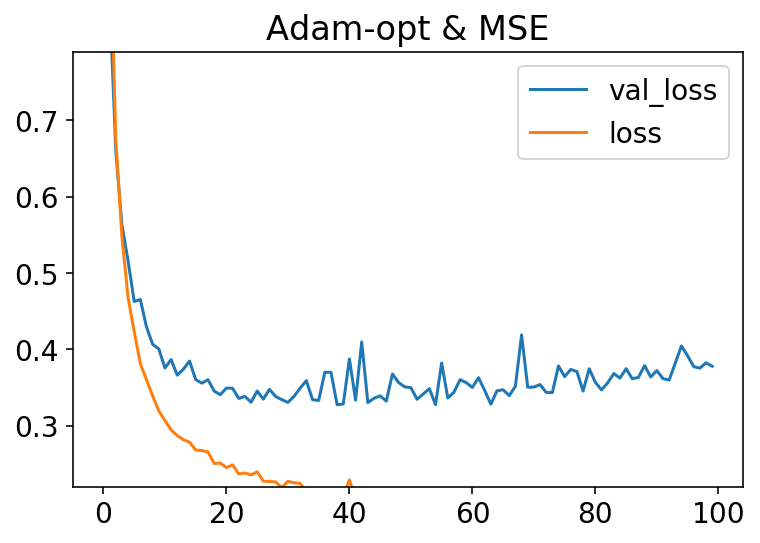

In [696]:
plt.plot(history_callback.history['val_loss'], label='val_loss')
plt.plot(history_callback.history['loss'], label='loss')
# plt.plot(history.history['val_acc'], label='val_acc')
# plt.plot(history.history['acc'], label='acc')
plt.ylim([0.22, 0.79])
plt.legend()
plt.title('Adam-opt & MSE')

In [697]:
convnet.evaluate(X_test_im,y_test_im)

1014/1014 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step


0.37259184003346535

In [626]:
print('mse score  = ', mse(convnet.predict(X_test_im),y_test_im) )

mse score  =  0.30836219374642665


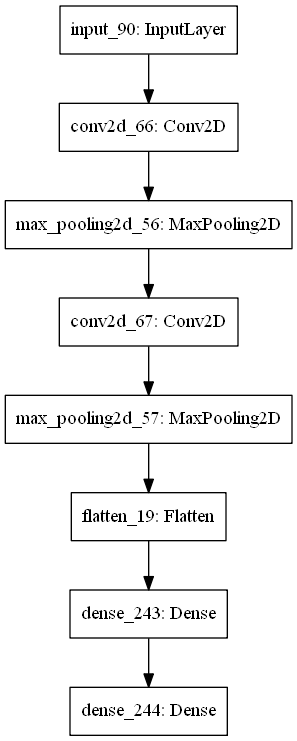

In [727]:
plot_model(convnet, to_file='img/conv-net.png')

Image(filename="img/conv-net.png")

## Let's try to combine both types of NN. One with vector input and convolutional with image input.

In [634]:
from keras.layers.merge import concatenate

In [707]:
inputs1 = Input(shape=(50,))
x = BatchNormalization()(inputs1)
x = Dense(500,activation='relu')(x)
# x = Dense(50,activation='relu')(x)
# x = Dropout(0.05, noise_shape=None, seed=None)(x)
# x = Dense(22,activation='relu')(inputs)

x = BatchNormalization()(x)
x = Dense(20,activation='relu')(x)
# x = Dropout(0.05, noise_shape=None, seed=None)(x)

# x = BatchNormalization()(x)
out1 = Dense(5,activation='linear')(x)

inputs2 = Input(shape=(62, 111, 1))
x = Conv2D(32, 4, strides=2, activation='relu')(inputs2)
x = MaxPool2D(2, strides=2)(x)
x = Conv2D(64, 2, strides=1, activation='relu')(x)
x = MaxPool2D(2, strides=2)(x)

out2 = Flatten()(x)

# merge input models
merge = concatenate([out1, out2])
# interpretation model
x = Dense(10, activation='relu')(merge)
x = Dense(10, activation='relu')(x)
output = Dense(5, activation='linear')(x)
combined = Model(inputs=[inputs1, inputs2], outputs=output)

In [708]:
combined.compile(optimizer='adam',
                loss='mean_squared_error'
                )

In [709]:
history_combined = combined.fit( [X_train, X_train_im], y_train_im,
                               batch_size=32,
                               epochs=60, verbose=2,
                               validation_data=([X_test, X_test_im], y_test_im))

Train on 4056 samples, validate on 1014 samples
Epoch 1/60
 - 16s - loss: 19.4097 - val_loss: 1.9594
Epoch 2/60
 - 11s - loss: 0.8243 - val_loss: 0.4763
Epoch 3/60
 - 15s - loss: 0.3806 - val_loss: 0.3617
Epoch 4/60
 - 16s - loss: 0.3697 - val_loss: 0.3568
Epoch 5/60
 - 12s - loss: 0.3563 - val_loss: 0.3640
Epoch 6/60
 - 13s - loss: 0.3238 - val_loss: 0.3360
Epoch 7/60
 - 12s - loss: 0.3182 - val_loss: 0.3650
Epoch 8/60
 - 13s - loss: 0.3281 - val_loss: 0.3359
Epoch 9/60
 - 14s - loss: 0.3305 - val_loss: 0.3421
Epoch 10/60
 - 12s - loss: 0.3222 - val_loss: 0.3647
Epoch 11/60
 - 14s - loss: 0.3258 - val_loss: 0.3336
Epoch 12/60
 - 16s - loss: 0.3108 - val_loss: 0.3320
Epoch 13/60
 - 15s - loss: 0.3062 - val_loss: 0.3223
Epoch 14/60
 - 17s - loss: 0.3100 - val_loss: 0.3299
Epoch 15/60
 - 16s - loss: 0.3013 - val_loss: 0.3174
Epoch 16/60
 - 12s - loss: 0.3091 - val_loss: 0.3394
Epoch 17/60
 - 12s - loss: 0.3103 - val_loss: 0.4122
Epoch 18/60
 - 12s - loss: 0.2998 - val_loss: 0.3503
Epoch 

Text(0.5,1,'Adam-opt & MSE')

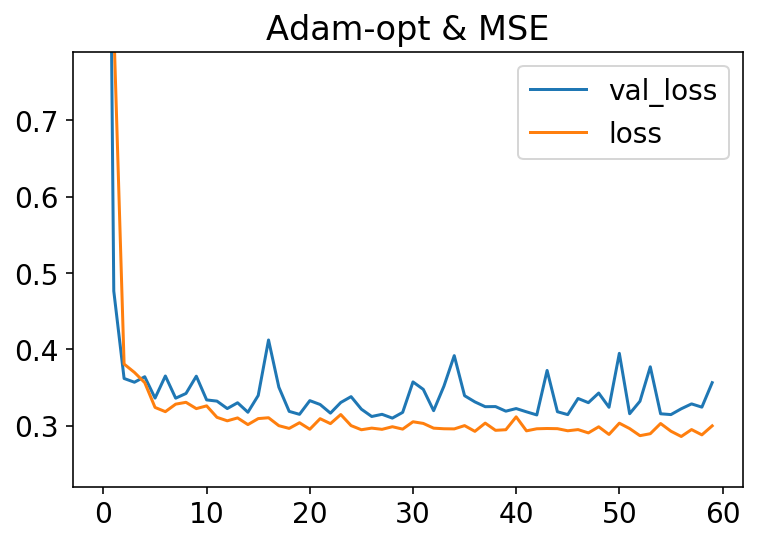

In [710]:
plt.plot(history_combined.history['val_loss'], label='val_loss')
plt.plot(history_combined.history['loss'], label='loss')
# plt.plot(history.history['val_acc'], label='val_acc')
# plt.plot(history.history['acc'], label='acc')
plt.ylim([0.22, 0.79])
plt.legend()
plt.title('Adam-opt & MSE')

In [712]:
combined.evaluate([X_test,X_test_im],y_test_im)

1014/1014 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 1ms/step


0.35622153091712816

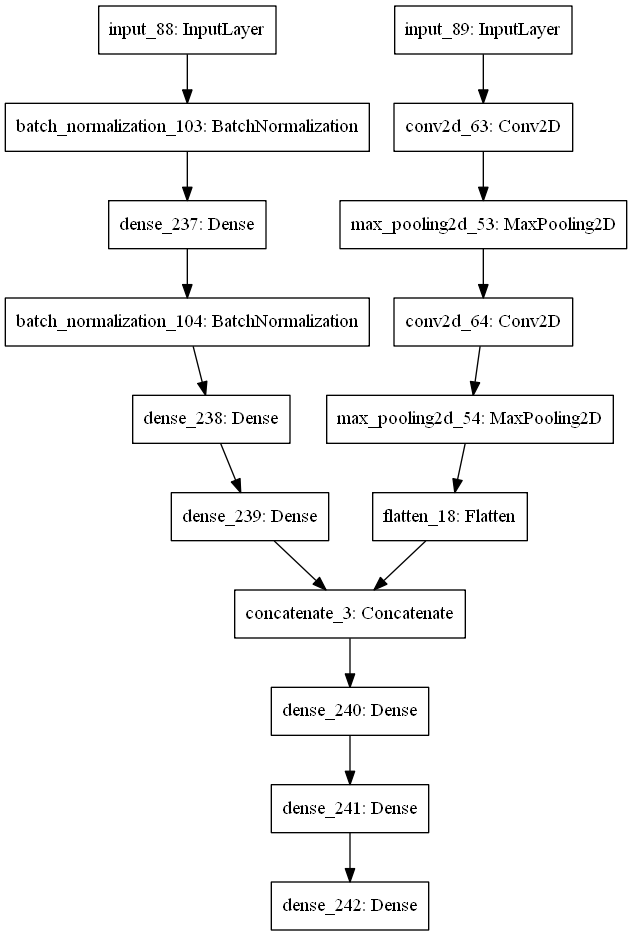

In [726]:
plot_model(combined, to_file='img/double-net.png')

Image(filename="img/double-net.png")